In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import os
# print(os.getcwd())

In [88]:

csv_path = "../../results/minimal/merged_output_filled_final.csv"
df = pd.read_csv(csv_path) 

df.columns = df.columns.str.strip()

In [89]:
# Ensure correct dtypes
bool_cols = ["judge_answer_correctness_vs_ref", "judge_answer_helpfulness"]
for col in bool_cols:
    if df[col].dtype != bool:
        df[col] = df[col].astype(str).str.lower().isin(["true", "1", "yes"])

numeric_cols = ["meta_total_tokens"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

In [90]:

# --- Clean up total_elapsed_time column ---
def parse_seconds(x):
    """Convert strings like '12 seconds' or '1.5 s' to float seconds."""
    if pd.isna(x):
        return None
    import re
    match = re.search(r"([\d\.]+)", str(x))
    return float(match.group(1)) if match else None

df["total_elapsed_time_sec"] = df["total_elapsed_time"].apply(parse_seconds)


# --- ESTIMATED price per run ---
def compute_price(row):
    """
    Compute cost (in USD) based on model type and total tokens.
    Prices per 1M tokens:
      gpt-nano: $0.40
      gpt-mini: $2.00
    """
    tokens = row.get("meta_total_tokens", 0)
    model = str(row.get("model", "")).lower()
    
    if "nano" in model:
        price_per_million = 0.40
    elif "mini" in model:
        price_per_million = 2.00
    else:
        # Default if model not recognized
        price_per_million = 1.00  

    return (tokens / 1_000_000) * price_per_million

df["price_usd"] = df.apply(compute_price, axis=1)

# --- Group and Aggregate ---
group_cols = ["approach", "model", "top_k"]

agg_df = (
    df.groupby(group_cols)
      .agg(
          avg_meta_total_tokens=("meta_total_tokens", "mean"),
          avg_price_usd=("price_usd", "mean"),
          avg_latency_sec=("total_elapsed_time_sec", "mean"),
          true_correctness_count=("judge_answer_correctness_vs_ref", "sum"),
          total_correctness_count=("judge_answer_correctness_vs_ref", "count"),
          true_helpfulness_count=("judge_answer_helpfulness", "sum"),
          total_helpfulness_count=("judge_answer_helpfulness", "count"),
      )
      .reset_index()
)

In [91]:
# Add percentage columns
agg_df["pct_correctness_true"] = (
    agg_df["true_correctness_count"] / agg_df["total_correctness_count"] * 100
)
agg_df["pct_helpfulness_true"] = (
    agg_df["true_helpfulness_count"] / agg_df["total_helpfulness_count"] * 100
)

In [92]:

# --- Summary ---
print("Summary of metrics by (approach, model, top_k):")
display(agg_df)

Summary of metrics by (approach, model, top_k):


,approach,model,top_k,avg_meta_total_tokens,avg_price_usd,avg_latency_sec,true_correctness_count,total_correctness_count,true_helpfulness_count,total_helpfulness_count,pct_correctness_true,pct_helpfulness_true
0,graph_eager,gpt-5-mini-2025-08-07,3,2297.250000,0.004594,13.744500,30,60,36,60,50.000000,60.000000
1,graph_eager,gpt-5-mini-2025-08-07,7,2294.916667,0.004590,13.841167,31,60,34,60,51.666667,56.666667
2,graph_eager,gpt-5-nano-2025-08-07,3,2266.166667,0.000906,12.922333,25,60,30,60,41.666667,50.000000
3,graph_eager,gpt-5-nano-2025-08-07,7,2257.266667,0.000903,12.491000,24,60,30,60,40.000000,50.000000
4,graph_mmr,gpt-5-mini-2025-08-07,3,4010.533333,0.008021,13.743500,37,60,40,60,61.666667,66.666667
5,graph_mmr,gpt-5-mini-2025-08-07,7,4011.666667,0.008023,13.829000,35,60,44,60,58.333333,73.333333
6,graph_mmr,gpt-5-nano-2025-08-07,3,3966.283333,0.001587,12.651000,30,60,35,60,50.000000,58.333333
7,graph_mmr,gpt-5-nano-2025-08-07,7,3962.100000,0.001585,12.493500,30,60,38,60,50.000000,63.333333
8,lc_bm25,gpt-5-mini-2025-08-07,3,9697.700000,0.019395,4.201667,44,60,49,60,73.333333,81.666667
9,lc_bm25,gpt-5-mini-2025-08-07,7,9694.633333,0.019389,4.134167,43,60,48,60,71.666667,80.000000


In [93]:

# # --- Visualization Setup ---
# sns.set(style="whitegrid", palette="muted")

# # Function to plot bar charts for each metric
# def plot_metric(metric, title):
#     plt.figure(figsize=(10, 6))
#     sns.barplot(
#         data=agg_df,
#         x="top_k", y=metric,
#         hue="model"
#     )
#     plt.title(title)
#     plt.xlabel("top_k")
#     plt.ylabel(metric)
#     plt.legend(title="Model")
#     plt.tight_layout()
#     plt.show()

In [94]:

# # --- Plot metrics ---
# plot_metric("avg_cosine", "Average Cosine Similarity by Model/Top-K")
# plot_metric("avg_rougeL", "Average ROUGE-L by Model/Top-K")
# plot_metric("avg_bleu", "Average BLEU by Model/Top-K")
# plot_metric("avg_meta_total_tokens", "Average Total Tokens by Model/Top-K")
# plot_metric("pct_correctness_true", "% Correctness TRUE by Model/Top-K")
# plot_metric("pct_helpfulness_true", "% Helpfulness TRUE by Model/Top-K")


In [95]:

# --- Heatmap comparison ---
heatmap_df = (
    agg_df.groupby(["approach", "model"])
    [["pct_correctness_true", "pct_helpfulness_true"]]
    .mean()
    .reset_index()
)

In [96]:
# =======================================
# Section 8: Evaluate Best Combinations
# =======================================

# Sort and display top combinations by correctness
best_correctness = agg_df.sort_values("pct_correctness_true", ascending=False)
best_helpfulness = agg_df.sort_values("pct_helpfulness_true", ascending=False)

print("\nTop combinations by % Correctness TRUE:")
display(best_correctness[[
    "approach", "model", "top_k", 
    "pct_correctness_true",
]])

print("\nTop combinations by % Helpfulness TRUE:")
display(best_helpfulness[[
    "approach", "model", "top_k", 
    "pct_helpfulness_true",
]])


Top combinations by % Correctness TRUE:


,approach,model,top_k,pct_correctness_true
13,openai_keyword,gpt-5-mini-2025-08-07,7,85.000000
16,openai_semantic,gpt-5-mini-2025-08-07,3,81.666667
12,openai_keyword,gpt-5-mini-2025-08-07,3,80.000000
17,openai_semantic,gpt-5-mini-2025-08-07,7,80.000000
21,vanilla,gpt-5-mini-2025-08-07,7,76.666667
8,lc_bm25,gpt-5-mini-2025-08-07,3,73.333333
9,lc_bm25,gpt-5-mini-2025-08-07,7,71.666667
15,openai_keyword,gpt-5-nano-2025-08-07,7,71.666667
18,openai_semantic,gpt-5-nano-2025-08-07,3,71.666667
19,openai_semantic,gpt-5-nano-2025-08-07,7,68.333333



Top combinations by % Helpfulness TRUE:


,approach,model,top_k,pct_helpfulness_true
17,openai_semantic,gpt-5-mini-2025-08-07,7,88.333333
13,openai_keyword,gpt-5-mini-2025-08-07,7,88.333333
16,openai_semantic,gpt-5-mini-2025-08-07,3,86.666667
12,openai_keyword,gpt-5-mini-2025-08-07,3,83.333333
21,vanilla,gpt-5-mini-2025-08-07,7,81.666667
15,openai_keyword,gpt-5-nano-2025-08-07,7,81.666667
8,lc_bm25,gpt-5-mini-2025-08-07,3,81.666667
9,lc_bm25,gpt-5-mini-2025-08-07,7,80.000000
19,openai_semantic,gpt-5-nano-2025-08-07,7,76.666667
18,openai_semantic,gpt-5-nano-2025-08-07,3,73.333333


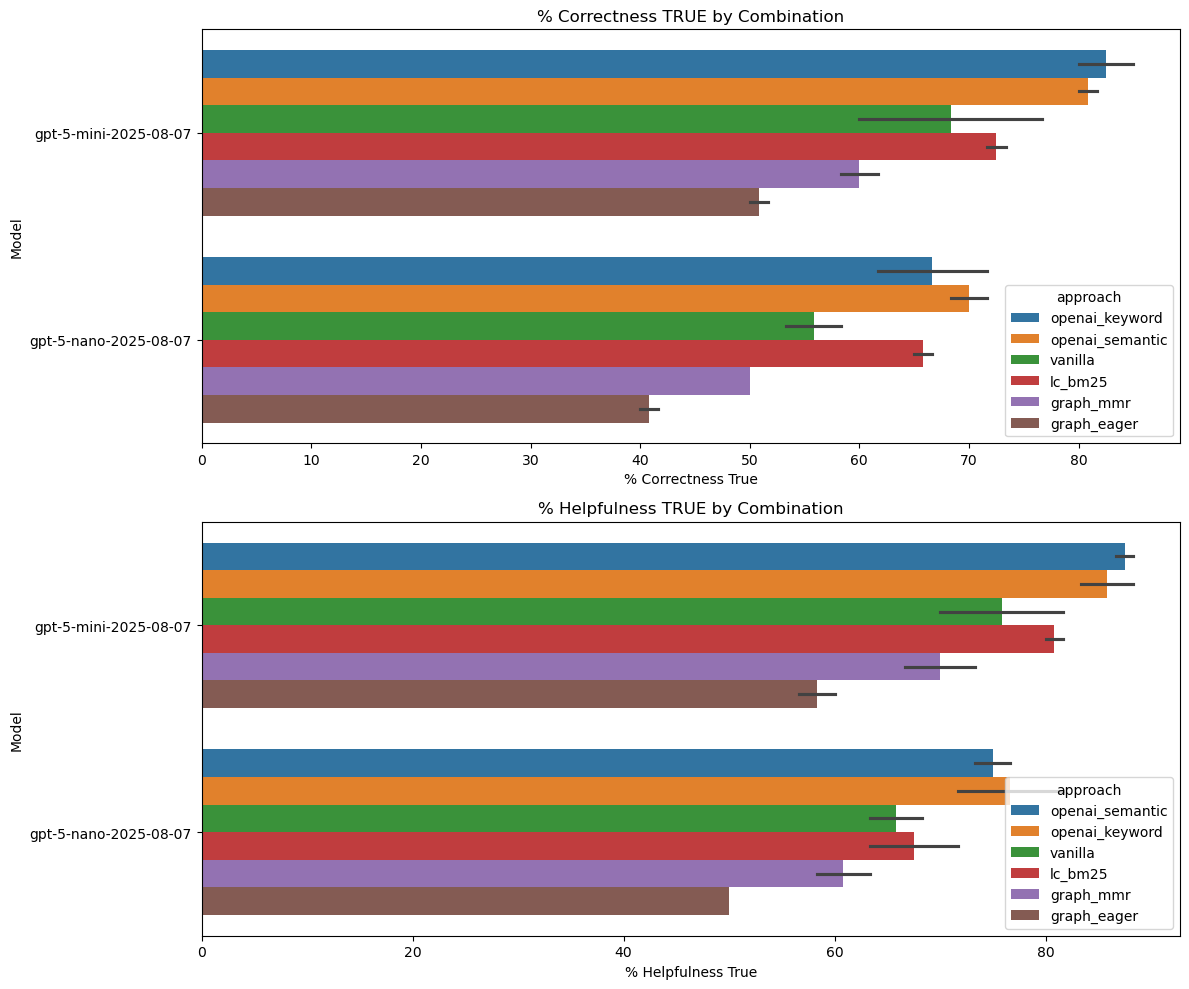

In [97]:
# =======================================
# Visual Comparison Bar Charts
# =======================================

# Combine metrics in one figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
sns.barplot(
    data=agg_df.sort_values("pct_correctness_true", ascending=False),
    x="pct_correctness_true", 
    y="model", 
    hue="approach", 
    ax=axes[0]
)
axes[0].set_title("% Correctness TRUE by Combination")
axes[0].set_xlabel("% Correctness True")
axes[0].set_ylabel("Model")

sns.barplot(
    data=agg_df.sort_values("pct_helpfulness_true", ascending=False),
    x="pct_helpfulness_true", 
    y="model", 
    hue="approach", 
    ax=axes[1]
)
axes[1].set_title("% Helpfulness TRUE by Combination")
axes[1].set_xlabel("% Helpfulness True")
axes[1].set_ylabel("Model")

plt.tight_layout()
plt.show()

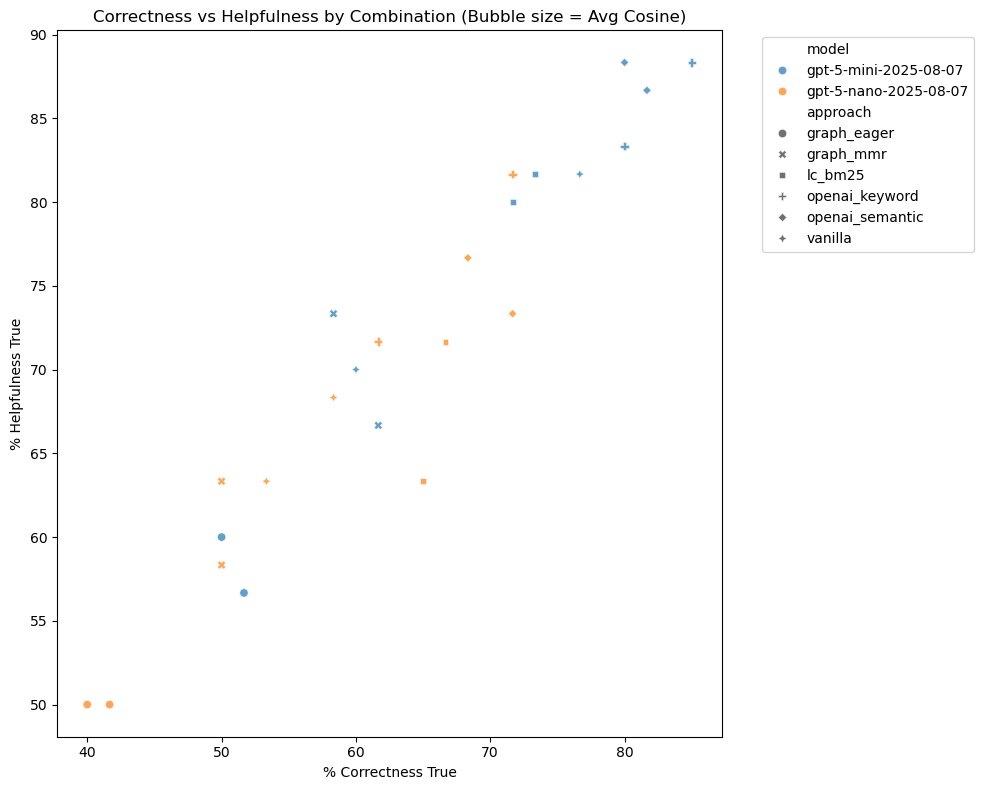

In [98]:
# =======================================
# Annotated Bubble Chart
# =======================================

# Bubble chart: each combination plotted by correctness vs helpfulness
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(
    data=agg_df,
    x="pct_correctness_true",
    y="pct_helpfulness_true",
    hue="model",
    style="approach",
    sizes=(100, 600),
    alpha=0.7
)
plt.title("Correctness vs Helpfulness by Combination (Bubble size = Avg Cosine)")
plt.xlabel("% Correctness True")
plt.ylabel("% Helpfulness True")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [99]:

# =======================================
# Combined Scoring View
# =======================================

# Create a composite ranking score (normalized 0–1)
from sklearn.preprocessing import MinMaxScaler # type: ignore

scaler = MinMaxScaler()
agg_df[["score_correctness", "score_helpfulness"]] = scaler.fit_transform(
    agg_df[["pct_correctness_true", "pct_helpfulness_true"]]
)
agg_df["combined_score"] = (agg_df["score_correctness"] + agg_df["score_helpfulness"]) / 2

ranked = agg_df.sort_values("score_correctness", ascending=False)
ranked["rank"] = 0
print(agg_df.columns)

for idx, (i,row) in enumerate(ranked.iterrows()):
    ranked.loc[i, "rank"] = idx
print("\nRanked by Combined Correctness+Helpfulness Score:")
display(ranked[[
    "rank", "approach", "model", "top_k", "avg_latency_sec", "avg_meta_total_tokens", "avg_price_usd",
    "pct_correctness_true", "pct_helpfulness_true", "combined_score"
]])

Index(['approach', 'model', 'top_k', 'avg_meta_total_tokens', 'avg_price_usd',
       'avg_latency_sec', 'true_correctness_count', 'total_correctness_count',
       'true_helpfulness_count', 'total_helpfulness_count',
       'pct_correctness_true', 'pct_helpfulness_true', 'score_correctness',
       'score_helpfulness', 'combined_score'],
      dtype='object')

Ranked by Combined Correctness+Helpfulness Score:


,rank,approach,model,top_k,avg_latency_sec,avg_meta_total_tokens,avg_price_usd,pct_correctness_true,pct_helpfulness_true,combined_score
13,0,openai_keyword,gpt-5-mini-2025-08-07,7,6.255000,18568.900000,0.037138,85.000000,88.333333,1.000000
16,1,openai_semantic,gpt-5-mini-2025-08-07,3,6.450667,8708.083333,0.017416,81.666667,86.666667,0.941224
12,2,openai_keyword,gpt-5-mini-2025-08-07,3,5.972500,8614.383333,0.017229,80.000000,83.333333,0.879227
17,3,openai_semantic,gpt-5-mini-2025-08-07,7,6.748333,18121.200000,0.036242,80.000000,88.333333,0.944444
21,4,vanilla,gpt-5-mini-2025-08-07,7,10.617833,11507.250000,0.023015,76.666667,81.666667,0.820451
8,5,lc_bm25,gpt-5-mini-2025-08-07,3,4.201667,9697.700000,0.019395,73.333333,81.666667,0.783414
9,6,lc_bm25,gpt-5-mini-2025-08-07,7,4.134167,9694.633333,0.019389,71.666667,80.000000,0.743156
15,7,openai_keyword,gpt-5-nano-2025-08-07,7,4.736000,18507.950000,0.007403,71.666667,81.666667,0.764895
18,8,openai_semantic,gpt-5-nano-2025-08-07,3,4.853500,8551.516667,0.003421,71.666667,73.333333,0.656200
19,9,openai_semantic,gpt-5-nano-2025-08-07,7,4.950833,17969.216667,0.007188,68.333333,76.666667,0.662641


In [100]:
# display(ranked[[
#     "rank", "approach", "model", "top_k", 
#     "pct_correctness_true", "pct_helpfulness_true", "combined_score"
# ]].head(5))

display(ranked[[
    "rank", "approach", "model", "top_k", "avg_latency_sec", "avg_meta_total_tokens", "avg_price_usd",
    "pct_correctness_true", "pct_helpfulness_true", "combined_score"
]].head(5))

,rank,approach,model,top_k,avg_latency_sec,avg_meta_total_tokens,avg_price_usd,pct_correctness_true,pct_helpfulness_true,combined_score
13,0,openai_keyword,gpt-5-mini-2025-08-07,7,6.255000,18568.900000,0.037138,85.000000,88.333333,1.000000
16,1,openai_semantic,gpt-5-mini-2025-08-07,3,6.450667,8708.083333,0.017416,81.666667,86.666667,0.941224
12,2,openai_keyword,gpt-5-mini-2025-08-07,3,5.972500,8614.383333,0.017229,80.000000,83.333333,0.879227
17,3,openai_semantic,gpt-5-mini-2025-08-07,7,6.748333,18121.200000,0.036242,80.000000,88.333333,0.944444
21,4,vanilla,gpt-5-mini-2025-08-07,7,10.617833,11507.250000,0.023015,76.666667,81.666667,0.820451


In [101]:
# =======================================
# Combined Latency View
# =======================================

# Create a composite ranking score (normalized 0–1)
from sklearn.preprocessing import MinMaxScaler # type: ignore

scaler = MinMaxScaler()
agg_df[["score_correctness", "score_helpfulness"]] = scaler.fit_transform(
    agg_df[["pct_correctness_true", "pct_helpfulness_true"]]
)
agg_df["combined_score"] = (agg_df["score_correctness"] + agg_df["score_helpfulness"]) / 2

ranked = agg_df.sort_values("avg_latency_sec", ascending=True)
ranked["rank"] = 0
print(agg_df.columns)

for idx, (i,row) in enumerate(ranked.iterrows()):
    ranked.loc[i, "rank"] = idx
print("\nRanked by Combined Latency Score:")
display(ranked[[
    "rank", "approach", "model", "top_k", "avg_latency_sec", "avg_meta_total_tokens", "avg_price_usd",
    "pct_correctness_true", "pct_helpfulness_true", "combined_score"
]])

Index(['approach', 'model', 'top_k', 'avg_meta_total_tokens', 'avg_price_usd',
       'avg_latency_sec', 'true_correctness_count', 'total_correctness_count',
       'true_helpfulness_count', 'total_helpfulness_count',
       'pct_correctness_true', 'pct_helpfulness_true', 'score_correctness',
       'score_helpfulness', 'combined_score'],
      dtype='object')

Ranked by Combined Latency Score:


,rank,approach,model,top_k,avg_latency_sec,avg_meta_total_tokens,avg_price_usd,pct_correctness_true,pct_helpfulness_true,combined_score
11,0,lc_bm25,gpt-5-nano-2025-08-07,7,2.576167,9636.066667,0.003854,65.000000,63.333333,0.451691
10,1,lc_bm25,gpt-5-nano-2025-08-07,3,2.890500,9652.066667,0.003861,66.666667,71.666667,0.578905
9,2,lc_bm25,gpt-5-mini-2025-08-07,7,4.134167,9694.633333,0.019389,71.666667,80.000000,0.743156
8,3,lc_bm25,gpt-5-mini-2025-08-07,3,4.201667,9697.700000,0.019395,73.333333,81.666667,0.783414
14,4,openai_keyword,gpt-5-nano-2025-08-07,3,4.380167,8605.783333,0.003442,61.666667,71.666667,0.523349
15,5,openai_keyword,gpt-5-nano-2025-08-07,7,4.736000,18507.950000,0.007403,71.666667,81.666667,0.764895
18,6,openai_semantic,gpt-5-nano-2025-08-07,3,4.853500,8551.516667,0.003421,71.666667,73.333333,0.656200
19,7,openai_semantic,gpt-5-nano-2025-08-07,7,4.950833,17969.216667,0.007188,68.333333,76.666667,0.662641
12,8,openai_keyword,gpt-5-mini-2025-08-07,3,5.972500,8614.383333,0.017229,80.000000,83.333333,0.879227
13,9,openai_keyword,gpt-5-mini-2025-08-07,7,6.255000,18568.900000,0.037138,85.000000,88.333333,1.000000


In [102]:
# =======================================
# Combined Token View
# =======================================

# Create a composite ranking score (normalized 0–1)
from sklearn.preprocessing import MinMaxScaler # type: ignore

scaler = MinMaxScaler()
agg_df[["score_correctness", "score_helpfulness"]] = scaler.fit_transform(
    agg_df[["pct_correctness_true", "pct_helpfulness_true"]]
)
agg_df["combined_score"] = (agg_df["score_correctness"] + agg_df["score_helpfulness"]) / 2

ranked = agg_df.sort_values("avg_meta_total_tokens", ascending=True)
ranked["rank"] = 0
print(agg_df.columns)

for idx, (i,row) in enumerate(ranked.iterrows()):
    ranked.loc[i, "rank"] = idx
print("\nRanked by Token Score:")
display(ranked[[
    "rank", "approach", "model", "top_k", "avg_latency_sec", "avg_meta_total_tokens", "avg_price_usd",
    "pct_correctness_true", "pct_helpfulness_true", "combined_score"
]])

Index(['approach', 'model', 'top_k', 'avg_meta_total_tokens', 'avg_price_usd',
       'avg_latency_sec', 'true_correctness_count', 'total_correctness_count',
       'true_helpfulness_count', 'total_helpfulness_count',
       'pct_correctness_true', 'pct_helpfulness_true', 'score_correctness',
       'score_helpfulness', 'combined_score'],
      dtype='object')

Ranked by Token Score:


,rank,approach,model,top_k,avg_latency_sec,avg_meta_total_tokens,avg_price_usd,pct_correctness_true,pct_helpfulness_true,combined_score
3,0,graph_eager,gpt-5-nano-2025-08-07,7,12.491000,2257.266667,0.000903,40.000000,50.000000,0.000000
2,1,graph_eager,gpt-5-nano-2025-08-07,3,12.922333,2266.166667,0.000906,41.666667,50.000000,0.018519
1,2,graph_eager,gpt-5-mini-2025-08-07,7,13.841167,2294.916667,0.004590,51.666667,56.666667,0.216586
0,3,graph_eager,gpt-5-mini-2025-08-07,3,13.744500,2297.250000,0.004594,50.000000,60.000000,0.241546
7,4,graph_mmr,gpt-5-nano-2025-08-07,7,12.493500,3962.100000,0.001585,50.000000,63.333333,0.285024
6,5,graph_mmr,gpt-5-nano-2025-08-07,3,12.651000,3966.283333,0.001587,50.000000,58.333333,0.219807
4,6,graph_mmr,gpt-5-mini-2025-08-07,3,13.743500,4010.533333,0.008021,61.666667,66.666667,0.458132
5,7,graph_mmr,gpt-5-mini-2025-08-07,7,13.829000,4011.666667,0.008023,58.333333,73.333333,0.508052
22,8,vanilla,gpt-5-nano-2025-08-07,3,8.241167,5357.733333,0.002143,53.333333,63.333333,0.322061
20,9,vanilla,gpt-5-mini-2025-08-07,3,10.058667,5443.666667,0.010887,60.000000,70.000000,0.483092


In [103]:
# =======================================
# Combined Price View
# =======================================

# Create a composite ranking score (normalized 0–1)
from sklearn.preprocessing import MinMaxScaler # type: ignore

scaler = MinMaxScaler()
agg_df[["score_correctness", "score_helpfulness"]] = scaler.fit_transform(
    agg_df[["pct_correctness_true", "pct_helpfulness_true"]]
)
agg_df["combined_score"] = (agg_df["score_correctness"] + agg_df["score_helpfulness"]) / 2

ranked = agg_df.sort_values("avg_price_usd", ascending=True)
ranked["rank"] = 0
print(agg_df.columns)

for idx, (i,row) in enumerate(ranked.iterrows()):
    ranked.loc[i, "rank"] = idx
print("\nRanked by Price Score:")
display(ranked[[
    "rank", "approach", "model", "top_k", "avg_latency_sec", "avg_meta_total_tokens", "avg_price_usd",
    "pct_correctness_true", "pct_helpfulness_true", "combined_score"
]])

Index(['approach', 'model', 'top_k', 'avg_meta_total_tokens', 'avg_price_usd',
       'avg_latency_sec', 'true_correctness_count', 'total_correctness_count',
       'true_helpfulness_count', 'total_helpfulness_count',
       'pct_correctness_true', 'pct_helpfulness_true', 'score_correctness',
       'score_helpfulness', 'combined_score'],
      dtype='object')

Ranked by Price Score:


,rank,approach,model,top_k,avg_latency_sec,avg_meta_total_tokens,avg_price_usd,pct_correctness_true,pct_helpfulness_true,combined_score
3,0,graph_eager,gpt-5-nano-2025-08-07,7,12.491000,2257.266667,0.000903,40.000000,50.000000,0.000000
2,1,graph_eager,gpt-5-nano-2025-08-07,3,12.922333,2266.166667,0.000906,41.666667,50.000000,0.018519
7,2,graph_mmr,gpt-5-nano-2025-08-07,7,12.493500,3962.100000,0.001585,50.000000,63.333333,0.285024
6,3,graph_mmr,gpt-5-nano-2025-08-07,3,12.651000,3966.283333,0.001587,50.000000,58.333333,0.219807
22,4,vanilla,gpt-5-nano-2025-08-07,3,8.241167,5357.733333,0.002143,53.333333,63.333333,0.322061
18,5,openai_semantic,gpt-5-nano-2025-08-07,3,4.853500,8551.516667,0.003421,71.666667,73.333333,0.656200
14,6,openai_keyword,gpt-5-nano-2025-08-07,3,4.380167,8605.783333,0.003442,61.666667,71.666667,0.523349
11,7,lc_bm25,gpt-5-nano-2025-08-07,7,2.576167,9636.066667,0.003854,65.000000,63.333333,0.451691
10,8,lc_bm25,gpt-5-nano-2025-08-07,3,2.890500,9652.066667,0.003861,66.666667,71.666667,0.578905
23,9,vanilla,gpt-5-nano-2025-08-07,7,8.445000,11436.150000,0.004574,58.333333,68.333333,0.442834


In [104]:

# =======================================
# Combined TOTAL View
# =======================================

# Create a composite ranking score (normalized 0–1)
from sklearn.preprocessing import MinMaxScaler # type: ignore

scaler = MinMaxScaler()
agg_df[["score_correctness", "score_helpfulness", "price_usd", "latency_sec"]] = scaler.fit_transform(
    agg_df[["pct_correctness_true", "pct_helpfulness_true", "avg_price_usd", "avg_latency_sec"]]
)
agg_df["combined_score"] = (agg_df["score_correctness"] + agg_df["score_helpfulness"] + agg_df["price_usd"] + agg_df["latency_sec"]) / 4

ranked = agg_df.sort_values("combined_score", ascending=False)
ranked["rank"] = 0
print(agg_df.columns)

for idx, (i,row) in enumerate(ranked.iterrows()):
    ranked.loc[i, "rank"] = idx
print("\nRanked by Combined Correctness+Helpfulness+Price+Latency Score:")
display(ranked[[
    "rank", "approach", "model", "top_k", "avg_latency_sec", "avg_meta_total_tokens", "avg_price_usd",
    "pct_correctness_true", "pct_helpfulness_true", "combined_score"
]])

Index(['approach', 'model', 'top_k', 'avg_meta_total_tokens', 'avg_price_usd',
       'avg_latency_sec', 'true_correctness_count', 'total_correctness_count',
       'true_helpfulness_count', 'total_helpfulness_count',
       'pct_correctness_true', 'pct_helpfulness_true', 'score_correctness',
       'score_helpfulness', 'combined_score', 'price_usd', 'latency_sec'],
      dtype='object')

Ranked by Combined Correctness+Helpfulness+Price+Latency Score:


,rank,approach,model,top_k,avg_latency_sec,avg_meta_total_tokens,avg_price_usd,pct_correctness_true,pct_helpfulness_true,combined_score
13,0,openai_keyword,gpt-5-mini-2025-08-07,7,6.255000,18568.900000,0.037138,85.000000,88.333333,0.831643
17,1,openai_semantic,gpt-5-mini-2025-08-07,7,6.748333,18121.200000,0.036242,80.000000,88.333333,0.808636
21,2,vanilla,gpt-5-mini-2025-08-07,7,10.617833,11507.250000,0.023015,76.666667,81.666667,0.741249
16,3,openai_semantic,gpt-5-mini-2025-08-07,3,6.450667,8708.083333,0.017416,81.666667,86.666667,0.670529
12,4,openai_keyword,gpt-5-mini-2025-08-07,3,5.972500,8614.383333,0.017229,80.000000,83.333333,0.627626
8,5,lc_bm25,gpt-5-mini-2025-08-07,3,4.201667,9697.700000,0.019395,73.333333,81.666667,0.555369
5,6,graph_mmr,gpt-5-mini-2025-08-07,7,13.829000,4011.666667,0.008023,58.333333,73.333333,0.552883
9,7,lc_bm25,gpt-5-mini-2025-08-07,7,4.134167,9694.633333,0.019389,71.666667,80.000000,0.533700
4,8,graph_mmr,gpt-5-mini-2025-08-07,3,13.743500,4010.533333,0.008021,61.666667,66.666667,0.526010
20,9,vanilla,gpt-5-mini-2025-08-07,3,10.058667,5443.666667,0.010887,60.000000,70.000000,0.476489


In [105]:

combo_1 = {
    "approach": "openai_keyword",
    "model": "gpt-5-mini-2025-08-07",
    "top_k": 7,
}
combo_2 = {
    "approach": "openai_semantic",
    "model": "gpt-5-mini-2025-08-07",
    "top_k": 3,
}

compare_df = df[
    ((df["approach"] == combo_1["approach"]) & 
     (df["model"] == combo_1["model"]) & 
     (df["top_k"] == combo_1["top_k"])) |
    ((df["approach"] == combo_2["approach"]) & 
     (df["model"] == combo_2["model"]) & 
     (df["top_k"] == combo_2["top_k"]))
]

print(f"Subset shape: {compare_df.shape}")
print(compare_df[["approach", "model", "top_k"]].drop_duplicates())

question_compare_df = (
    compare_df.groupby(["question", "approach", "model", "top_k"])
    .agg(
        avg_price_usd=("price_usd", "mean"),
        avg_latency_sec=("total_elapsed_time_sec", "mean"),
        avg_meta_total_tokens=("meta_total_tokens", "mean"),
        true_correctness_count=("judge_answer_correctness_vs_ref", "sum"),
        total_correctness_count=("judge_answer_correctness_vs_ref", "count"),
        true_helpfulness_count=("judge_answer_helpfulness", "sum"),
        total_helpfulness_count=("judge_answer_helpfulness", "count"),
    )
    .reset_index()
)

# Derived percentages
question_compare_df["pct_correctness_true"] = (
    question_compare_df["true_correctness_count"]
    / question_compare_df["total_correctness_count"] * 100
)
question_compare_df["pct_helpfulness_true"] = (
    question_compare_df["true_helpfulness_count"]
    / question_compare_df["total_helpfulness_count"] * 100
)

print("\nQuestion-level results for selected configurations:")
display(
    question_compare_df[[
        "question",
        "approach",
        "model",
        "top_k",
        "avg_latency_sec",
        "avg_meta_total_tokens",
        "avg_price_usd",
        "pct_correctness_true",
        "pct_helpfulness_true",
    ]]
    .sort_values(["question", "approach"])
)


Subset shape: (120, 31)
            approach                  model  top_k
505   openai_keyword  gpt-5-mini-2025-08-07      7
720  openai_semantic  gpt-5-mini-2025-08-07      3

Question-level results for selected configurations:


,question,approach,model,top_k,avg_latency_sec,avg_meta_total_tokens,avg_price_usd,pct_correctness_true,pct_helpfulness_true
0,Are there risks associated with using 12V vs 24V?,openai_keyword,gpt-5-mini-2025-08-07,7,6.42,20584.0,0.041168,100.0,100.0
1,Are there risks associated with using 12V vs 24V?,openai_semantic,gpt-5-mini-2025-08-07,3,6.15,9106.0,0.018212,100.0,100.0
2,Can I connect or disconnect my teach pendant w...,openai_keyword,gpt-5-mini-2025-08-07,7,4.08,21095.0,0.042190,100.0,100.0
3,Can I connect or disconnect my teach pendant w...,openai_semantic,gpt-5-mini-2025-08-07,3,4.55,7310.0,0.014620,100.0,100.0
4,Can I skip setting a password for the safety s...,openai_keyword,gpt-5-mini-2025-08-07,7,5.67,14960.0,0.029920,100.0,100.0
...,...,...,...,...,...,...,...,...,...
115,Why do I need to set the center of gravity for...,openai_semantic,gpt-5-mini-2025-08-07,3,6.96,7628.0,0.015256,100.0,100.0
116,Why does my robot arm look to be vibrating whe...,openai_keyword,gpt-5-mini-2025-08-07,7,6.05,18850.0,0.037700,100.0,100.0
117,Why does my robot arm look to be vibrating whe...,openai_semantic,gpt-5-mini-2025-08-07,3,6.83,8636.0,0.017272,100.0,100.0
118,Why is the robot arm moving slowly or stopping...,openai_keyword,gpt-5-mini-2025-08-07,7,10.62,18080.0,0.036160,100.0,100.0


In [106]:
combo_1 = {
    "approach": "openai_keyword",
    "model": "gpt-5-mini-2025-08-07",
    "top_k": 7,
}
combo_2 = {
    "approach": "openai_semantic",
    "model": "gpt-5-mini-2025-08-07",
    "top_k": 3,
}

# --- Filter the main dataframe for just these groups ---
compare_df = df[
    ((df["approach"] == combo_1["approach"]) & 
     (df["model"] == combo_1["model"]) & 
     (df["top_k"] == combo_1["top_k"])) |
    ((df["approach"] == combo_2["approach"]) & 
     (df["model"] == combo_2["model"]) & 
     (df["top_k"] == combo_2["top_k"]))
].copy()

print(f"Subset shape: {compare_df.shape}")
print(compare_df[["approach", "model", "top_k"]].drop_duplicates())

# --- Compute per-question correctness ---
question_compare_df = (
    compare_df.groupby(["question", "approach"])
    .agg(
        true_correctness_count=("judge_answer_correctness_vs_ref", "sum"),
        total_correctness_count=("judge_answer_correctness_vs_ref", "count"),
    )
    .reset_index()
)

# Binary 1/0 correctness per question (100% = True)
question_compare_df["is_correct"] = (
    question_compare_df["true_correctness_count"]
    / question_compare_df["total_correctness_count"]
) == 1.0

# --- Pivot into side-by-side comparison ---
pivot_correct = question_compare_df.pivot_table(
    index="question", columns="approach", values="is_correct"
).reset_index()

# Drop questions not answered by both
pivot_correct = pivot_correct.dropna(subset=[combo_1["approach"], combo_2["approach"]])

# --- Determine which approach "won" each question ---
pivot_correct["winner"] = pivot_correct.apply(
    lambda x: (
        combo_1["approach"]
        if (x[combo_1["approach"]] and not x[combo_2["approach"]])
        else (combo_2["approach"]
              if (x[combo_2["approach"]] and not x[combo_1["approach"]])
              else "tie")
    ),
    axis=1,
)

# --- Split into categories ---
questions_keyword_won = pivot_correct[pivot_correct["winner"] == combo_1["approach"]]
questions_semantic_won = pivot_correct[pivot_correct["winner"] == combo_2["approach"]]
questions_tied = pivot_correct[pivot_correct["winner"] == "tie"]

# --- Display tables ---
print(f"\n{combo_1['approach']} got right where {combo_2['approach']} missed:")
display(questions_keyword_won[["question", combo_1["approach"], combo_2["approach"]]])

print(f"\n{combo_2['approach']} got right where {combo_1['approach']} missed:")
display(questions_semantic_won[["question", combo_1["approach"], combo_2["approach"]]])

print(f"\nQuestions both got right or both missed:")
display(questions_tied[["question", combo_1["approach"], combo_2["approach"]]])

# --- Summary counts ---
summary_counts = pivot_correct["winner"].value_counts().reset_index()
summary_counts.columns = ["winner", "num_questions"]
print("\nSummary of question-level outcomes:")
display(summary_counts)



Subset shape: (120, 31)
            approach                  model  top_k
505   openai_keyword  gpt-5-mini-2025-08-07      7
720  openai_semantic  gpt-5-mini-2025-08-07      3

openai_keyword got right where openai_semantic missed:


approach,question,openai_keyword,openai_semantic
21,Is it ok to use any type of packaging to move ...,1.0,0.0
32,What are the tool attachments I can put on the...,1.0,0.0
50,What risks do I need to be aware of for the sa...,1.0,0.0



openai_semantic got right where openai_keyword missed:


approach,question,openai_keyword,openai_semantic
36,What check procedures do I need to follow afte...,0.0,1.0



Questions both got right or both missed:


approach,question,openai_keyword,openai_semantic
0,Are there risks associated with using 12V vs 24V?,1.0,1.0
1,Can I connect or disconnect my teach pendant w...,1.0,1.0
2,Can I skip setting a password for the safety s...,1.0,1.0
3,Can I use bleach as a cleaning agent? What sho...,1.0,1.0
4,Can you describe the robot stop categories?,1.0,1.0
5,Do I need to worry about a strong electromagne...,1.0,1.0
6,How can I reduce the force applied to the oper...,1.0,1.0
7,How can I set up my active program so that I o...,1.0,1.0
8,How do I clean the machine?,1.0,1.0
9,How do I ensure the robot elbow and tool remai...,1.0,1.0



Summary of question-level outcomes:


,winner,num_questions
0,tie,56
1,openai_keyword,3
2,openai_semantic,1
